[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eneskelestemur/MolecularModeling/blob/main/Labs/lab02_databases/Databases.ipynb)

# Databases

**Topics:**

* [Databases](#databases)

## Databases

### Table of Contents

1. [ChEMBL Database](#chembl-database)
2. [PubChem Database](#pubchem-database)
3. [PDB Database](#pdb-database)


### ChEMBL Database

<div style="text-align: center"><img src="images/ChEMBL_web_service_diagram.png" width="75%"></div>

**ChEMBL Database** is a manually curated database of bioactive molecules with drug-like properties. It contains information on approximately 2 million compounds, their bioactivities, and associated drug targets. The data in ChEMBL is derived from scientific literature and is often used in drug discovery and development processes.

**Data fetching and downloading from ChEMBL** can be efficiently done using the ChEMBL Web Resource Client, which allows easy access to ChEMBL data via the REST API. Researchers can query for molecules, targets, and bioactivities using various filters and retrieve data in a structured format for further analysis.

To learn more about how ChEMBL Web Resource Client, you can visit their [github](https://github.com/chembl/chembl_webresource_client) and [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4489243/)

To get a sense of how useful ChEMBL Web Resource Client is, we will walk through a few examples:
* How to retrieve molecules from ChEMBL
* Retrieving protein target-based data
* Retrieving bioactivity data

In [1]:
%pip install chembl_webresource_client

['activity', 'activity_supplementary_data_by_activity', 'assay', 'assay_class', 'atc_class', 'binding_site', 'biotherapeutic', 'cell_line', 'chembl_id_lookup', 'chembl_release', 'compound_record', 'compound_structural_alert', 'description', 'document', 'document_similarity', 'drug', 'drug_indication', 'drug_warning', 'go_slim', 'image', 'mechanism', 'metabolism', 'molecule', 'molecule_form', 'official', 'organism', 'protein_classification', 'similarity', 'source', 'substructure', 'target', 'target_component', 'target_relation', 'tissue', 'xref_source']


In [ ]:
from chembl_webresource_client.new_client import new_client

# available data entities
available_resources = [resource for resource in dir(new_client) if not resource.startswith('_')]
available_resources

**Available filters**

The design of the client is based on [Django QuerySet](https://docs.djangoproject.com/en/1.11/ref/models/querysets) and most important lookup types are supported. These are:

- exact
- iexact
- contains
- icontains
- in
- gt
- gte
- lt
- lte
- startswith
- istartswith
- endswith
- iendswith
- range
- isnull
- regex
- iregex


**Only operator**

`only` is a special method allowing to limit the results to a selected set of fields. `only` should take a single argument: a list of fields that should be included in result. Specified fields have to exists in the endpoint against which `only` is executed. Using `only` will usually make an API call faster because less information returned will save bandwidth. The API logic will also check if any SQL joins are necessary to return the specified field and exclude unnecessary joins with critically improves performance.

Please note that only has one limitation: a list of fields will ignore nested fields i.e. calling `only(['molecule_properties__alogp'])` is equivalent to `only(['molecule_properties'])`.

For many-to-many relationships only will not make any SQL join optimisation.

#### Molecules

Molecule records may be retrieved in a number of ways. We will go through some examples.

In [2]:
# find a molecule by pref_name
molecule = new_client.molecule
mols = molecule.filter(pref_name__iexact='aspirin')
print(mols[0])

[{'atc_classifications': ['B01AC06', 'N02BA01', 'N02BA51', 'A01AD05', 'N02BA71'], 'availability_type': 2, 'biotherapeutic': None, 'black_box_warning': 0, 'chebi_par_id': 15365, 'chemical_probe': 0, 'chirality': 2, 'cross_references': [{'xref_id': 'aspirin', 'xref_name': 'aspirin', 'xref_src': 'DailyMed'}, {'xref_id': '144203627', 'xref_name': 'SID: 144203627', 'xref_src': 'PubChem'}, {'xref_id': '144209315', 'xref_name': 'SID: 144209315', 'xref_src': 'PubChem'}, {'xref_id': '144210466', 'xref_name': 'SID: 144210466', 'xref_src': 'PubChem'}, {'xref_id': '170465039', 'xref_name': 'SID: 170465039', 'xref_src': 'PubChem'}, {'xref_id': '17389202', 'xref_name': 'SID: 17389202', 'xref_src': 'PubChem'}, {'xref_id': '17390036', 'xref_name': 'SID: 17390036', 'xref_src': 'PubChem'}, {'xref_id': '174007205', 'xref_name': 'SID: 174007205', 'xref_src': 'PubChem'}, {'xref_id': '26747283', 'xref_name': 'SID: 26747283', 'xref_src': 'PubChem'}, {'xref_id': '26752858', 'xref_name': 'SID: 26752858', 'xref

In [3]:
# use of only() to retrieve only specific fields
molecule = new_client.molecule
mols = molecule.filter(pref_name__iexact='aspirin').only('molecule_chembl_id', 'pref_name')
print(mols)

[{'molecule_chembl_id': 'CHEMBL25', 'pref_name': 'ASPIRIN'}]


In [4]:
# get many molecules by their ChEMBL IDs
molecule = new_client.molecule
mols = molecule.filter(molecule_chembl_id__in=['CHEMBL25', 'CHEMBL112', 'CHEMBL521']).only('molecule_chembl_id', 'pref_name')
print(mols)

[{'molecule_chembl_id': 'CHEMBL25', 'pref_name': 'ASPIRIN'}, {'molecule_chembl_id': 'CHEMBL521', 'pref_name': 'IBUPROFEN'}, {'molecule_chembl_id': 'CHEMBL112', 'pref_name': 'ACETAMINOPHEN'}]


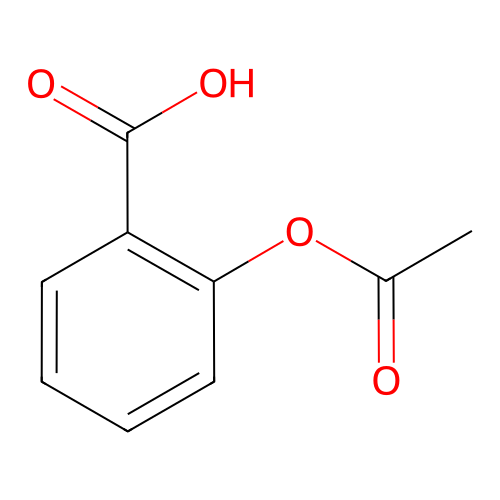

In [5]:
from IPython.display import SVG

# get image of a molecule
image = new_client.image
image.set_format('svg')
img = image.get('CHEMBL25')
SVG(img)

In [6]:
# get molecule structure
molecule = new_client.molecule
mols = molecule.filter(molecule_chembl_id='CHEMBL25').only('molecule_structures')
print(mols[0])

[{'molecule_structures': {'canonical_smiles': 'CC(=O)Oc1ccccc1C(=O)O', 'molfile': '\n     RDKit          2D\n\n 13 13  0  0  0  0  0  0  0  0999 V2000\n   19.8052   -4.2758    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   19.8040   -5.0953    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   20.5121   -5.5043    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   21.2217   -5.0948    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   21.2189   -4.2722    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   20.5103   -3.8669    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   20.5078   -3.0497    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   21.2143   -2.6390    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n   19.7989   -2.6432    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n   21.9250   -3.8609    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n   22.6343   -4.2668    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n   23.3405   -3.8556    0.0000 C   0  0  0  0  0  0  0  0  0  0  0 

In [7]:
# find molecules similar to a given SMILES query with similarity threshold of 80%
similarity = new_client.similarity
mols = similarity.filter(smiles='CC(=O)Oc1ccccc1C(=O)O', similarity=80).only('molecule_chembl_id', 'pref_name')
for mol in mols:
    print(mol)

{'molecule_chembl_id': 'CHEMBL2296002', 'pref_name': None}
{'molecule_chembl_id': 'CHEMBL1697753', 'pref_name': 'ASPIRIN DL-LYSINE'}
{'molecule_chembl_id': 'CHEMBL25', 'pref_name': 'ASPIRIN'}
{'molecule_chembl_id': 'CHEMBL3833404', 'pref_name': 'CARBASPIRIN'}
{'molecule_chembl_id': 'CHEMBL3833325', 'pref_name': 'CARBASPIRIN CALCIUM'}
{'molecule_chembl_id': 'CHEMBL350343', 'pref_name': 'DIPLOSALSALATE'}


In [8]:
# find molecules similar to a given ChEMBL ID with similarity threshold of 70%
similarity = new_client.similarity
mols = similarity.filter(chembl_id='CHEMBL25', similarity=80).only('molecule_chembl_id', 'pref_name')
for mol in mols:
    print(mol)

{'molecule_chembl_id': 'CHEMBL2296002', 'pref_name': None}
{'molecule_chembl_id': 'CHEMBL1697753', 'pref_name': 'ASPIRIN DL-LYSINE'}
{'molecule_chembl_id': 'CHEMBL3833404', 'pref_name': 'CARBASPIRIN'}
{'molecule_chembl_id': 'CHEMBL3833325', 'pref_name': 'CARBASPIRIN CALCIUM'}
{'molecule_chembl_id': 'CHEMBL350343', 'pref_name': 'DIPLOSALSALATE'}


In [9]:
# get all approved drugs
molecule = new_client.molecule
approved_drugs = molecule.filter(max_phase=4).only('molecule_chembl_id', 'pref_name').order_by('molecule_properties__mw_freebase')
approved_drugs

[{'molecule_chembl_id': 'CHEMBL1796997', 'pref_name': 'HELIUM'}, {'molecule_chembl_id': 'CHEMBL1160819', 'pref_name': 'AMMONIA SOLUTION, STRONG'}, {'molecule_chembl_id': 'CHEMBL1201189', 'pref_name': 'AMMONIA N 13'}, {'molecule_chembl_id': 'CHEMBL1098659', 'pref_name': 'WATER'}, '...(remaining elements truncated)...']

In [10]:
# get approved drugs for lung cancer
drug_indication = new_client.drug_indication
molecule = new_client.molecule

lung_cancer_ind = drug_indication.filter(efo_term__icontains='LUNG CARCINOMA') # pull drugs related to lung cancer
chembl_ids = [x['molecule_chembl_id'] for x in lung_cancer_ind] # get ChEMBL IDs
lung_cancer_drugs = molecule.filter(molecule_chembl_id__in=chembl_ids).only('molecule_chembl_id', 'pref_name')
print(len(lung_cancer_drugs))
lung_cancer_drugs

760


[{'molecule_chembl_id': 'CHEMBL413', 'pref_name': 'SIROLIMUS'}, {'molecule_chembl_id': 'CHEMBL417', 'pref_name': 'EPIRUBICIN'}, {'molecule_chembl_id': 'CHEMBL20', 'pref_name': 'ACETAZOLAMIDE'}, {'molecule_chembl_id': 'CHEMBL25', 'pref_name': 'ASPIRIN'}, '...(remaining elements truncated)...']

In [ ]:
# filter drugs by approval year and name
drug = new_client.drug
res = drug.filter(first_approval__gte=1980).filter(usan_stem="-azosin").only('molecule_chembl_id', 'first_approval', 'usan_stem', 'usan_stem_definition')
res

In [ ]:
# get all biotherapeutics
molecule = new_client.molecule
biotherapeutics = molecule.filter(biotherapeutic__isnull=False)
len(biotherapeutics)

In [ ]:
# get molecules with molecular weight between 100 and 200
molecule = new_client.molecule
mols = molecule.filter(molecule_properties__mw_freebase__gte=100, molecule_properties__mw_freebase__lte=200)
print(len(mols))

In [ ]:
# get molecules with molecular weight <= 300 and ends with 'nib'
molecule = new_client.molecule
light_nib_molecules = molecule.filter(molecule_properties__mw_freebase__lte=300, pref_name__iendswith="nib").only(['molecule_chembl_id', 'pref_name'])
light_nib_molecules

In [ ]:
# get molecules with no violations of Lipinski's rule of five
# Lipinski's rule of five states that a molecule is more likely to be orally bioavailable if it has:
# - no more than 5 hydrogen bond donors
# - no more than 10 hydrogen bond acceptors
# - a molecular weight less than 500
# - Calculated log of octanol-water partition (clogP) less than 5
molecule = new_client.molecule
no_violations = molecule.filter(molecule_properties__num_ro5_violations=0)
len(no_violations)

#### Targets

Examples of retrieving target data from ChEMBL:

In [ ]:
from chembl_webresource_client.new_client import new_client

# get targets for a given gene name
target = new_client.target
gene_name = 'BRD4'
res = target.filter(target_synonym__icontains=gene_name).only(['organism', 'pref_name', 'target_chembl_id', 'target_type'])
for i in res:
    print(i)

In [ ]:
# get target for a given ChEMBL ID
target = new_client.target
res = target.filter(target_chembl_id='CHEMBL217').only(['organism', 'pref_name', 'target_chembl_id', 'target_type'])
for i in res:
    print(i)

In [ ]:
# get targets for a given uniprot ID
target = new_client.target
targets = target.filter(target_components__accession='P04629').only(['organism', 'pref_name', 'target_chembl_id', 'target_type'])
for i in targets:
    print(i)

#### Activities

Examples of retrieving activity data from ChEMBL:

In [11]:
from chembl_webresource_client.new_client import new_client

# get all activities for a given target
target = new_client.target
activity = new_client.activity
herg = target.filter(pref_name__iexact='hERG').only('target_chembl_id')[0]
print(herg)
herg_activities = activity.filter(target_chembl_id=herg['target_chembl_id']).filter(standard_type="IC50")

len(herg_activities)

15530

In [12]:
# get all activities for a given target with assay type of B (binding)
activity = new_client.activity
activities = activity.filter(target_chembl_id='CHEMBL1824', assay_type='B')
len(activities)

6918

In [13]:
# get all activities with a pChEMBL for a molecule
activity = new_client.activity
activities = activity.filter(molecule_chembl_id='CHEMBL25', pchembl_value__isnull=False)
len(activities)

150

Lastly, it is important to note that we have not been downloading the data. In order to download and write the data to a file, we can use Pandas `DataFrame` object. Here is an example how we can save the fetched data from server.

In [ ]:
from chembl_webresource_client.new_client import new_client
import pandas as pd

# same thing as the first example, but we'll save the data this time
target = new_client.target
activity = new_client.activity
cyp = target.filter(pref_name__iexact='Cytochrome P450 4Z1').only('target_chembl_id')[0]
cyp_activities = activity.filter(
    target_chembl_id=cyp['target_chembl_id']
).only(
    'molecule_chembl_id',
    'target_pref_name',
    'standard_type',
    'standard_relation',
    'standard_value',
    'standard_units',
)
# print(cyp_activities)

# Up to this point, we don't have the data yet, we just have a query,
# but we can convert the query to a list to download the data, 
# or we can convert it to a DataFrame
cyp_activities_df = pd.DataFrame.from_records(cyp_activities)
cyp_activities_df


### PubChem Database

**PubChem Database** is an open chemistry database maintained by the NCBI, containing information on the biological activities of small molecules. It includes three main databases: Substance, Compound, and BioAssay, providing a comprehensive overview of the chemical and biological properties of molecules.

**The PUG REST (Power User Gateway Representational State Transfer) web service** is an API provided by PubChem that allows users to programmatically access the data in PubChem. It supports a variety of queries, including searching for chemical compounds, retrieving molecular information, and accessing biological assay data. 

To learn more about PUG REST, visit the [PUG REST website](https://pubchemdocs.ncbi.nlm.nih.gov/pug-rest) and the [tutorial](https://pubchem.ncbi.nlm.nih.gov/pug_rest/PUG_REST_Tutorial.html) provided by PubChem.

In the following examples we will be using [PubChemPy](https://pubchempy.readthedocs.io/en/latest/index.html) Python package. This is a simplified wrapper around PUG REST. However, it does not contain all the useful features of PUG REST. For more more complicated data pipelines, you should refer to the [PUG REST website](https://pubchemdocs.ncbi.nlm.nih.gov/pug-rest).

In [14]:
%pip install pubchempy

{'atom_stereo_count': 0,
 'atoms': [{'aid': 1, 'number': 16, 'element': 'S', 'y': -2.6739, 'x': 3},
  {'aid': 2, 'number': 8, 'element': 'O', 'y': 2.8649, 'x': 2.5},
  {'aid': 3, 'number': 8, 'element': 'O', 'y': 3.6739, 'x': 4.0878},
  {'aid': 4, 'number': 8, 'element': 'O', 'y': -2.6739, 'x': 2},
  {'aid': 5, 'number': 8, 'element': 'O', 'y': -2.6739, 'x': 4},
  {'aid': 6, 'number': 6, 'element': 'C', 'y': 1.3261, 'x': 3},
  {'aid': 7, 'number': 6, 'element': 'C', 'y': 0.3261, 'x': 3},
  {'aid': 8, 'number': 6, 'element': 'C', 'y': 1.9139, 'x': 3.809},
  {'aid': 9, 'number': 6, 'element': 'C', 'y': 1.9139, 'x': 2.191},
  {'aid': 10, 'number': 6, 'element': 'C', 'y': -1.6739, 'x': 3},
  {'aid': 11, 'number': 6, 'element': 'C', 'y': 1.6048, 'x': 4.7601},
  {'aid': 12, 'number': 6, 'element': 'C', 'y': -0.1739, 'x': 2.134},
  {'aid': 13, 'number': 6, 'element': 'C', 'y': -0.1739, 'x': 3.866},
  {'aid': 14, 'number': 6, 'element': 'C', 'y': 2.8649, 'x': 3.5},
  {'aid': 15, 'number': 6, '

In [ ]:
import pubchempy as pcp

# get compound by CID
compound = pcp.Compound.from_cid(5090)
compound.to_dict()

In [15]:
# access compound properties
compound = pcp.Compound.from_cid(5090)
print(compound.synonyms)
print(compound.isomeric_smiles)
print(compound.canonical_smiles)
print(compound.molecular_formula)
print(compound.molecular_weight)
print(compound.xlogp)

['rofecoxib', '162011-90-7', 'Vioxx', 'Ceoxx', 'MK 966', '4-(4-(Methylsulfonyl)phenyl)-3-phenylfuran-2(5H)-one', 'refecoxib', 'Vioxx Dolor', 'MK-966', '4-[4-(methylsulfonyl)phenyl]-3-phenylfuran-2(5H)-one', 'MK0966', '4-[4-(methylsulfonyl)phenyl]-3-phenyl-2(5H)-furanone', 'MK 0966', 'MK-0966', 'rofecoxibum', '3-(4-methylsulfonylphenyl)-4-phenyl-2H-furan-5-one', 'CCRIS 8967', 'HSDB 7262', 'TRM-201', 'UNII-0QTW8Z7MCR', '0QTW8Z7MCR', 'NSC-720256', 'NSC-758705', 'CHEBI:8887', 'DTXSID2023567', 'M01AH02', 'MK966', '3-phenyl-4-[4-(methylsulfonyl)phenyl]-2(5H)-furanone', '4-(4-(Methylsulfonyl)phenyl)-3-phenyl-2(5H)-furanone', '4-(p-(Methylsulfonyl)phenyl)-3-phenyl-2(5H)-furanone', '3-Phenyl-4-(4-(methylsulfonyl)phenyl))-2(5H)-furanone', '2(5H)-Furanone, 4-[4-(methylsulfonyl)phenyl]-3-phenyl-', '4-(4-methanesulfonylphenyl)-3-phenyl-2,5-dihydrofuran-2-one', 'CHEMBL122', '4-(4-methylsulfonylphenyl)-3-phenyl-5H-furan-2-one', 'DTXCID903567', 'TRM201', 'NSC720256', 'NSC 720256', 'NSC 758705', '2(5H)

In [16]:
# search for compounds by an identifier
# first arg: identifier
# second arg: namespace or identifier_type, e.g. 'name', 'smiles', 'inchi', 'inchikey'
compounds = pcp.get_compounds('acetaminophen', 'name')
print(compounds)
print(compounds[0].isomeric_smiles)

[Compound(1983)]
CC(=O)NC1=CC=C(C=C1)O


In [ ]:
# search for compounds by SMILES
compounds = pcp.get_compounds('CC(=O)Nc1ccc(O)cc1', 'smiles')
print(compounds)
print(compounds[0].synonyms)

In [ ]:
# retrieve only specific properties
compounds = pcp.get_properties(['IsomericSMILES', 'MolecularFormula', 'MolecularWeight'], 'CC(=O)Nc1ccc(O)cc1', 'smiles')
print(compounds)

In [ ]:
# search for compounds by similarity
compounds = pcp.get_compounds('CC(=O)Nc1ccc(O)cc1', 'smiles', searchtype='similarity', Threshold=90)
print(len(compounds))

### PDB Database

**The Protein Data Bank (PDB)** is a repository for the 3D structural data of large biological molecules. It is widely used in structural biology, molecular modeling, and bioinformatics to study the structure-function relationships of biomolecules.

**[Biopython](https://biopython.org/) package** is an open-source collection of tools for biological computation written in Python. It provides functionalities for working with sequences, structures, and other biological data, making it widely used in bioinformatics and computational biology.

`biopython` includes modules specifically designed for handling and analyzing structural data from PDB files. The `Bio.PDB` module allows users to parse PDB files, manipulate protein structures, and extract detailed information such as atoms, residues, chains, and secondary structure elements. This makes `biopython` an essential tool for researchers working with 3D biomolecular structures, enabling them to easily integrate structural data into their analyses and workflows.

<div style="text-align: center"><img src="images/biopython_structure.png" width="50%"/></div>

**[NGLView](https://nglviewer.org/nglview/latest/) package** is a Python package that provides an interactive widget for visualizing molecular structures directly in Jupyter notebooks. It is built on top of the NGL.js library and allows users to load, display, and interact with 3D structures from formats like PDB, MOL2, and others. With `nglview`, you can rotate, zoom, and explore molecular models, making it a powerful tool for visualizing biomolecular data in a user-friendly and interactive manner.

We will use `biopython` to explore PDB and manipulate protein structures retrieved directly from PDB. Additionally, we will use `nglview` to display prtotein structure within a Jupyter notebook environment.

In [17]:
%pip install biopython
%pip install nglview

Structure exists: './data\6jim.cif' 


'./data\\6jim.cif'

In [ ]:
from Bio.PDB import PDBList

# download a PDB file
pdbl = PDBList()
pdbl.retrieve_pdb_file('6JIM', pdir='./data', file_format='mmCif')

In [18]:
# download multiple PDB files
pdbl = PDBList()
pdbl.download_pdb_files(['6JIM', '1FAT'], pdir='./data', file_format='mmCif')

Structure exists: './data\6jim.cif' 
Structure exists: './data\1fat.cif' 


In [19]:
# download entire PDB
# this will take 2-4 days
pdbl = PDBList()
# pdbl.download_entire_pdb(file_format='mmCif')

In [20]:
# update the local copy of the PDB
pdbl = PDBList()
# pdbl.update_pdb(file_format='mmCif')

In [21]:
from Bio.PDB import MMCIFParser

# biopython Structure object
parser = MMCIFParser()
structure = parser.get_structure('6JIM', './data/6jim.cif')
structure

c:\Users\adamf\OneDrive\Documents\UNC\Courses\CBMC805\MolecularModeling\Labs\lab01_intro_python_rdkit\.conda\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7344.
  warnings.warn(
c:\Users\adamf\OneDrive\Documents\UNC\Courses\CBMC805\MolecularModeling\Labs\lab01_intro_python_rdkit\.conda\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7422.
  warnings.warn(
c:\Users\adamf\OneDrive\Documents\UNC\Courses\CBMC805\MolecularModeling\Labs\lab01_intro_python_rdkit\.conda\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7493.
  warnings.warn(
c:\Users\adamf\OneDrive\Documents\UNC\Courses\CBMC805\MolecularModeling\Labs\lab01_intro_python_rdkit\.conda\Lib\site-packages\Bio\PDB\StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7499.
  warnings.warn(
c:\U

<Structure id=6JIM>

In [22]:
# iterate over the structure
for model in structure:
    for chain in model:
        print(f'Chain {chain.get_id()}')
        for residue in chain:
            print(residue.get_id(), residue.get_resname(), end=': ')
            for atom in residue:
                print(atom.get_name(), end=',')
            print()

Chain A
(' ', 1, ' ') GLY: N,CA,C,O,
(' ', 2, ' ') ILE: N,CA,C,O,CB,CG1,CG2,CD1,
(' ', 3, ' ') ILE: N,CA,C,O,CB,CG1,CG2,CD1,
(' ', 4, ' ') GLU: N,CA,C,O,CB,
(' ', 5, ' ') THR: N,CA,C,O,CB,OG1,CG2,
(' ', 6, ' ') PRO: N,CA,C,O,CB,CG,CD,
(' ', 7, ' ') ARG: N,CA,C,O,CB,
(' ', 8, ' ') GLY: N,CA,C,O,
(' ', 9, ' ') ALA: N,CA,C,O,CB,
(' ', 10, ' ') ILE: N,CA,C,O,CB,CG1,CG2,CD1,
(' ', 11, ' ') LYS: N,CA,C,O,CB,CG,CD,CE,NZ,
(' ', 12, ' ') VAL: N,CA,C,O,CB,CG1,CG2,
(' ', 13, ' ') THR: N,CA,C,O,CB,OG1,CG2,
(' ', 14, ' ') ALA: N,CA,C,O,CB,
(' ', 15, ' ') GLN: N,CA,C,O,CB,CG,CD,OE1,NE2,
(' ', 16, ' ') PRO: N,CA,C,O,CB,CG,CD,
(' ', 17, ' ') THR: N,CA,C,O,CB,OG1,CG2,
(' ', 18, ' ') ASP: N,CA,C,O,CB,CG,OD1,OD2,
(' ', 19, ' ') HIS: N,CA,C,O,CB,CG,ND1,CD2,CE1,NE2,
(' ', 20, ' ') VAL: N,CA,C,O,CB,CG1,CG2,
(' ', 21, ' ') VAL: N,CA,C,O,CB,CG1,CG2,
(' ', 22, ' ') GLY: N,CA,C,O,
(' ', 23, ' ') GLU: N,CA,C,O,CB,CG,CD,OE1,OE2,
(' ', 24, ' ') TYR: N,CA,C,O,CB,CG,CD1,CD2,CE1,CE2,CZ,OH,
(' ', 25, ' ') LEU: N,CA,C,

In [23]:
# extract a specific atom from the structure
model = structure[0]
chain = model['A']
residue = chain[50]
atom = residue['CA']
# alternatively
atom = structure[0]['A'][50]['CA']
# print some properties of the atom
print(atom.element)
print(atom.get_name())
print(atom.get_coord())
print(atom.get_bfactor())
print(atom.get_occupancy())

C
CA
[31.074 -6.004 27.558]
80.39
1.0


In [24]:
# alternative way to navigate the structure
# iterate over the models
print('Models:')
for model in structure.get_models():
    print(model.get_id(), end=',')
print()
# iterate over the chains
print('Chains:')
for chain in structure.get_chains():
    print(chain.get_id(), end=',')
print()
# iterate over the residues
print('Residues:')
for residue in structure.get_residues():
    print(residue.get_resname(), end=',')
print()
# iterate over the atoms
print('Atoms:')
for atom in structure.get_atoms():
    print(atom.get_name(), end=',')

Models:
0,
Chains:
A,B,C,D,
Residues:
GLY,ILE,ILE,GLU,THR,PRO,ARG,GLY,ALA,ILE,LYS,VAL,THR,ALA,GLN,PRO,THR,ASP,HIS,VAL,VAL,GLY,GLU,TYR,LEU,VAL,LEU,SER,PRO,GLN,THR,VAL,LEU,ARG,SER,GLN,LYS,LEU,SER,LEU,ILE,HIS,ALA,LEU,ALA,GLU,GLN,VAL,LYS,THR,CYS,THR,HIS,ASN,GLY,TYR,ASP,GLY,ARG,VAL,LEU,VAL,PRO,SER,GLY,TYR,ALA,ILE,SER,PRO,GLU,ASP,PHE,GLN,SER,LEU,SER,GLU,SER,ALA,THR,MET,VAL,TYR,ASN,GLU,ARG,GLU,PHE,VAL,ASN,ARG,LYS,LEU,HIS,HIS,ILE,ALA,MET,HIS,GLY,PRO,ALA,LEU,ASN,THR,ASP,GLU,GLU,SER,TYR,GLU,LEU,VAL,ARG,ALA,GLU,ARG,THR,GLU,HIS,GLU,TYR,VAL,TYR,ASP,VAL,ASP,GLN,ARG,ARG,CYS,CYS,LYS,LYS,GLU,GLU,ALA,ALA,GLY,LEU,VAL,LEU,VAL,GLY,ASP,LEU,THR,ASN,PRO,PRO,TYR,HIS,GLU,PHE,ALA,TYR,GLU,GLY,LEU,LYS,ILE,ARG,PRO,ALA,CYS,PRO,TYR,LYS,ILE,ALA,VAL,ILE,GLY,VAL,PHE,GLY,VAL,PRO,GLY,SER,GLY,LYS,SER,ALA,ILE,ILE,LYS,ASN,LEU,VAL,THR,ARG,GLN,ASP,LEU,VAL,THR,SER,GLY,LYS,LYS,GLU,ASN,CYS,GLN,GLU,ILE,THR,THR,ASP,VAL,MET,ARG,GLN,ARG,GLY,LEU,GLU,ILE,SER,ALA,ARG,THR,VAL,ASP,SER,LEU,LEU,LEU,ASN,GLY,CYS,ASN,ARG,PRO,VAL,ASP,VAL,LEU,TY

In [25]:
# modifying the structure
chain_A = structure[0]['A']
# find all water residues
res_ids_to_remove = []
for residue in chain_A.get_residues():
    if residue.get_id()[0] == 'W':
        res_ids_to_remove.append(residue.get_id())

# remove the water residues
for res_id in res_ids_to_remove[::-1]:
    chain_A.detach_child(res_id)

# print the modified structure to verify the removal
for residue in structure[0]['A'].get_residues():
    print(residue.get_id(), residue.get_resname())

(' ', 1, ' ') GLY
(' ', 2, ' ') ILE
(' ', 3, ' ') ILE
(' ', 4, ' ') GLU
(' ', 5, ' ') THR
(' ', 6, ' ') PRO
(' ', 7, ' ') ARG
(' ', 8, ' ') GLY
(' ', 9, ' ') ALA
(' ', 10, ' ') ILE
(' ', 11, ' ') LYS
(' ', 12, ' ') VAL
(' ', 13, ' ') THR
(' ', 14, ' ') ALA
(' ', 15, ' ') GLN
(' ', 16, ' ') PRO
(' ', 17, ' ') THR
(' ', 18, ' ') ASP
(' ', 19, ' ') HIS
(' ', 20, ' ') VAL
(' ', 21, ' ') VAL
(' ', 22, ' ') GLY
(' ', 23, ' ') GLU
(' ', 24, ' ') TYR
(' ', 25, ' ') LEU
(' ', 26, ' ') VAL
(' ', 27, ' ') LEU
(' ', 28, ' ') SER
(' ', 29, ' ') PRO
(' ', 30, ' ') GLN
(' ', 31, ' ') THR
(' ', 32, ' ') VAL
(' ', 33, ' ') LEU
(' ', 34, ' ') ARG
(' ', 35, ' ') SER
(' ', 36, ' ') GLN
(' ', 37, ' ') LYS
(' ', 38, ' ') LEU
(' ', 39, ' ') SER
(' ', 40, ' ') LEU
(' ', 41, ' ') ILE
(' ', 42, ' ') HIS
(' ', 43, ' ') ALA
(' ', 44, ' ') LEU
(' ', 45, ' ') ALA
(' ', 46, ' ') GLU
(' ', 47, ' ') GLN
(' ', 48, ' ') VAL
(' ', 49, ' ') LYS
(' ', 50, ' ') THR
(' ', 51, ' ') CYS
(' ', 52, ' ') THR
(' ', 53, ' ') HIS
('

In [26]:
# let's make the above code into a function
def remove_water(chain_id, structure):
    chain = structure[0][chain_id]
    res_ids_to_remove = []
    for residue in chain.get_residues():
        if residue.get_id()[0] == 'W':
            res_ids_to_remove.append(residue.get_id())
    for res_id in res_ids_to_remove[::-1]:
        chain.detach_child(res_id)

# run the function for all chains in the structure
for chain in structure.get_chains():
    remove_water(chain.get_id(), structure)

In [27]:
from Bio.PDB import PDBIO

# save the modified structure
io = PDBIO()
io.set_structure(structure)
io.save('./data/6jim_modified.pdb')

In [30]:
import nglview as nv

# view structure in nglview
view = nv.show_biopython(structure)
view

NGLWidget()